In [6]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io, os, random, lmdb

sns.set(style="whitegrid")

Define the directory.

In [ ]:
from utils import DATASET_DIR
FOLDERNAME = "train1"
TRAIN_DIR = os.path.join(DATASET_DIR, FOLDERNAME)
EXPORT_DIR = os.path.join(DATASET_DIR, f"{FOLDERNAME}.xlsx")

Open the lmdb.

In [8]:
rows = []
env = lmdb.open(TRAIN_DIR, readonly=True, lock=False)

Load into DataFrame.

In [9]:
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:
        key_str = key.decode()

        if key_str.startswith("image_lr-"):
            idx = key_str.replace("image_lr-", "")
            label_key = f"label-{idx}".encode()

            label = txn.get(label_key)
            if label is not None:
                img = Image.open(io.BytesIO(value))
                width, height = img.size
                
                rows.append({
                    "id": idx,
                    "image_key": key_str,
                    "label": label.decode(),
                    "width": width,
                    "height": height
                })

df = pd.DataFrame(rows)

A glance of the dataset.

In [10]:
df.head(5)

,id,image_key,label,width,height
0,000000001,image_lr-000000001,inter,332,46
1,000000002,image_lr-000000002,COUNTIES,61,26
2,000000003,image_lr-000000003,BAY,31,23
3,000000004,image_lr-000000004,SERVICE.,206,47
4,000000005,image_lr-000000005,POSTAL,185,45


Export as Excel.

In [11]:
# df.to_excel(EXPORT_DIR, index=False, engine="xlsxwriter")

View the Images.

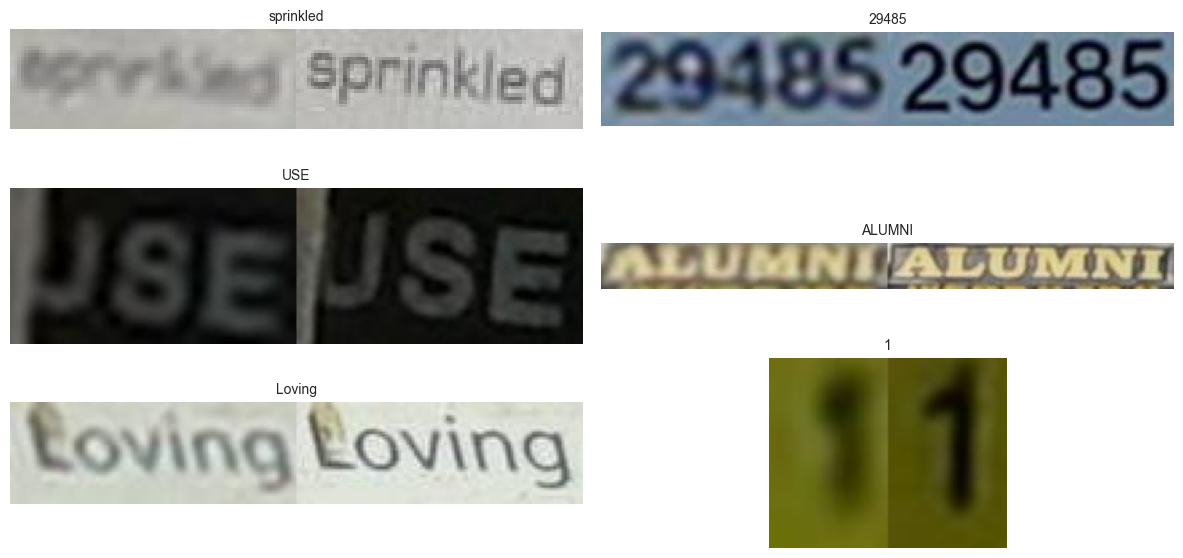

In [12]:
%matplotlib inline
row = 0
NUM_ROWS = 3
NUM_COLS = 2
NUM_SAMPLES = NUM_ROWS * NUM_COLS

sample_ids = df["id"].sample(NUM_SAMPLES).tolist()

fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(12, 6))

for i, idx in enumerate(sample_ids):
    row = i // NUM_COLS
    col = i % NUM_COLS

    with env.begin() as txn:
        lr_bytes = txn.get(f"image_lr-{idx}".encode())
        hr_bytes = txn.get(f"image_hr-{idx}".encode())
        label_bytes = txn.get(f"label-{idx}".encode())

    if not lr_bytes or not hr_bytes or not label_bytes:
        continue

    lr_img = Image.open(io.BytesIO(lr_bytes))
    hr_img = Image.open(io.BytesIO(hr_bytes))
    text = label_bytes.decode(errors="ignore")

    # Create a horizontal triplet for this sample
    axes[row, col].imshow(lr_img)
    axes[row, col].set_title(f"{text}\nLR | HR", fontsize=10)
    axes[row, col].axis("off")

    # Show LR and HR side-by-side as a single combined image
    # Option 1: concatenate LR + HR horizontally
    import numpy as np
    combined = np.concatenate([np.array(lr_img), np.array(hr_img)], axis=1)
    axes[row, col].imshow(combined)
    axes[row, col].set_title(text, fontsize=10)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

### Exploratory Data Analysis

Total number of the sample.

In [13]:
df.shape[0]

14573

Check the Aspect Ratio.

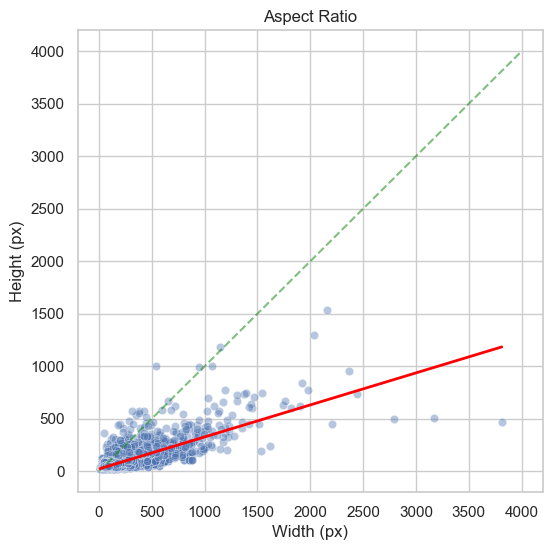

In [14]:
m, b = np.polyfit(df["width"], df["height"], 1)
x_line = np.array([df["width"].min(), df["width"].max()])
y_line = m * x_line + b

plt.figure(figsize=(6,6))
sns.scatterplot(x=df["width"], y=df["height"], alpha=0.4)

# add trend line
plt.plot([0, 4000], [0, 4000], color='green', linestyle='--', alpha=0.5, label='1:1 Ratio')

# add y=x line to visualize deviation from square
plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Trend Line (y={m:.2f}x + {b:.2f})')

plt.title("Aspect Ratio")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()

This tells us:
- Most images have a width under 500 pixels and a height under a 200 pixels.
- Some outliers exist that need to be removed.
- Longer words &rarr; wider images.
- Any model designed for this dataset must handle variable input or use robust resizing / padding techniques.

Check the distribution of the label length.

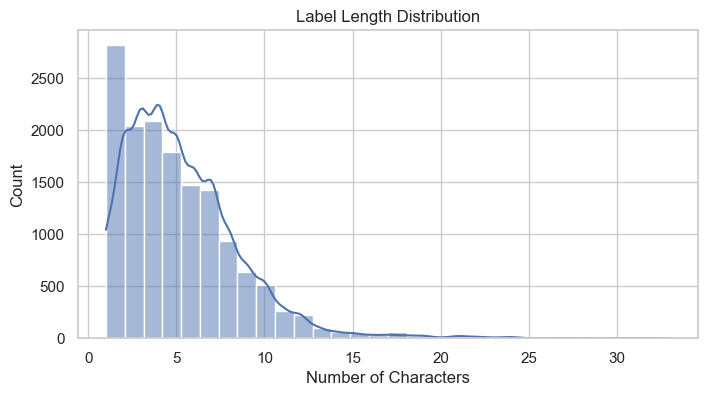

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df["label"].str.len(), bins=30, kde=True)
plt.title("Label Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()

In [16]:
print("Longest length:", max(df["label"].str.len()))

Longest length: 33


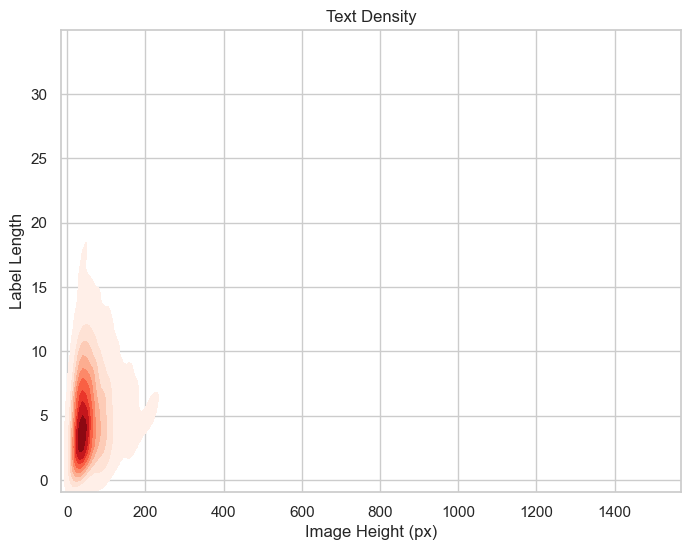

In [17]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df["height"],
    y=df["label"].str.len(),
    cmap="Reds",
    fill=True
)
plt.title("Text Density")
plt.xlabel("Image Height (px)")
plt.ylabel("Label Length")
plt.show()

Check the frequency of the characters.

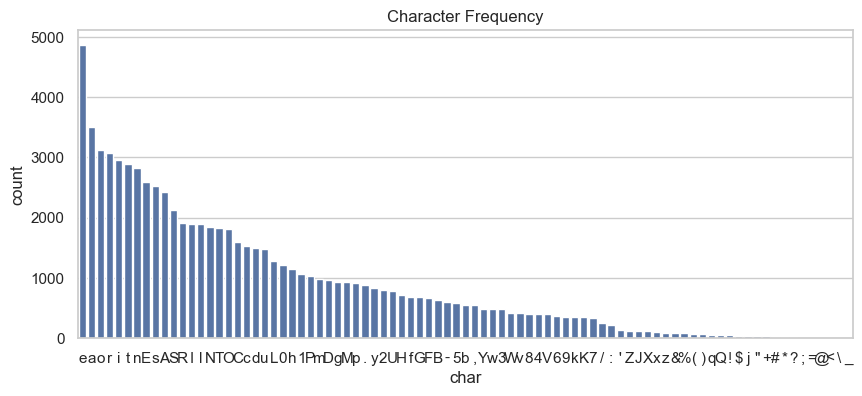

In [22]:
from collections import Counter

char_counts = Counter("".join(df["label"]))
char_df = pd.DataFrame(char_counts.items(), columns=["char", "count"])
char_df = char_df.sort_values("count", ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(data=char_df, x="char", y="count")
plt.title("Character Frequency")
plt.show()

This tells us:
- `e`, `a`, `o`, `r`, `i` are the most frequent.
- Lowercase letters are far more common than uppercase.
- `0` and `1` appear but are much less frequent than vowels.

A problem rises because:

- License plates are almost exclusively UPPERCASE.
- License plates are heavily numeric (often 50% numbers).
- License plates do not follow English grammar (e.g. "Q" and "Z" are rare in English but common on plates).